# Biophysical Variable Prediction in Scikit-Learn and Keras using PROSAIL Sentinel 2 Band Simulated Database
---

## Introduction
---

### Background
*Similar background to ALR paper*

### Objectives
The main objective of this paper is to compare the performance of SL2P(D) against the performance of a purely linear model which performs variable selection on the input bands, as well as the performance of the same linear model with the addition of a neural network which performs regression on the features selected by the linear model. In this case the feature selection will be performed by the least angle regression algorithm (Efron et al., 2002) provided by scikit-learn.

Specifically performance will be measured using the root mean squared error of each model as well as the absolute error in the model with respect to the specific true value of the response variables.

## Methodology
---

### Methods
Three methods were tested on the global PROSAIL dataset with 41472 samples simulated from various different biomes to estimate LAI, FCOVER, and FAPAR.
* SL2P
* LARS Regression
* LARS Regression + Keras (Tensorflow) Shallow Neural Network

The PROSAIL simulation generates Sentinel 2 bands:

| Band | Central Wavelength | Description | Resolution | 
|---|---|---|---|
| B3 | 560nm | green | 10m |
| B4 | 665nm | red | 10m |
| B5 | 705nm | VNIR | 20m res |
| B6 | 740nm | VNIR | 20m res |
| B7 | 783nm | VNIR | 20m res |
| B8A | 865nm | VNIR | 20m res |
| B11 | 1610nm | SWIR | 20m res |
| B12 | 2190nm | SWIR | 20m res |

*SL2P description* + `code`

In the script below the methodology used for LARS and the shallow neural network in Keras will be described further.

In [1]:
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy 
import pandas 
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
import tensorflow
import os

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
matlabData = sio.loadmat(file_name='./data/s2_sl2p_weiss_or_prosail_inout.mat', variable_names=['Input', 'Output'])

In [4]:
inputDF = pandas.DataFrame(data=matlabData['Input']['Rho_Toc'][0][0])
inputAngles = pandas.DataFrame(data=matlabData['Input']['Angles'][0][0])

inputDF = pandas.concat([inputDF, inputAngles], axis=1, join='outer', ignore_index=True)
inputDF.columns = ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3']

LAI = pandas.Series(data=matlabData['Output']['LAI'][0][0].flatten())
FAPAR = pandas.Series(data=matlabData['Output']['FAPAR'][0][0].flatten())
FCOVER = pandas.Series(data=matlabData['Output']['FCOVER'][0][0].flatten())

outputCSV = pandas.concat([inputDF, LAI, FAPAR, FCOVER], axis=1, join='outer')

outputCSV['latitude'] = 0
outputCSV['longitude'] = 0

outputCSV.columns = ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3', 
                     'LAI', 'FAPAR', 'FCOVER', 'latitude', 'longitude']
outputCSV

,B0,B1,B2,B3,B4,B5,B6,B7,A1,A2,A3,LAI,FAPAR,FCOVER,latitude,longitude
0,0.048953,0.030271,0.073742,0.294630,0.419698,0.436037,0.121603,0.043615,0.994435,0.853211,0.994632,6.014594,0.870412,0.875424,0,0
1,0.053655,0.029552,0.074523,0.383288,0.566787,0.597187,0.180981,0.054689,0.974949,0.899428,-0.974783,5.752335,0.957268,0.971936,0,0
2,0.075767,0.092849,0.144840,0.267414,0.306598,0.321708,0.254556,0.145838,0.970282,0.901471,0.982456,0.746137,0.386350,0.394260,0,0
3,0.071742,0.031115,0.094643,0.303518,0.383710,0.391068,0.118468,0.047038,0.987971,0.865112,-0.997234,5.374681,0.819419,0.830017,0,0
4,0.100043,0.028230,0.130998,0.442701,0.560120,0.563746,0.182785,0.062757,0.961521,0.385027,0.490117,5.467322,0.899630,0.927706,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41467,0.091781,0.028950,0.124602,0.420813,0.528081,0.544847,0.122709,0.032790,0.979430,0.704338,0.746313,4.951841,0.922245,0.949148,0,0
41468,0.046467,0.034942,0.069040,0.229278,0.308859,0.321834,0.126807,0.071680,0.994707,0.654700,-0.672963,4.453112,0.717015,0.714964,0,0
41469,0.045621,0.027923,0.067862,0.307144,0.445989,0.474847,0.162763,0.055750,0.999777,0.576598,-0.587336,4.579922,0.861480,0.871602,0,0
41470,0.053039,0.037354,0.081990,0.340293,0.506438,0.528001,0.190817,0.076028,0.988945,0.729268,0.771352,5.502935,0.879030,0.882815,0,0


In [5]:
#outputCSV.to_csv(path_or_buf=r'rawFeatures.csv')

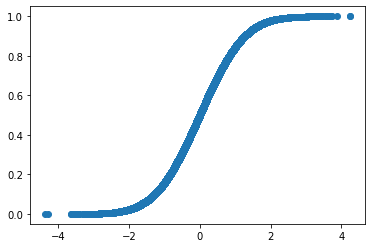

In [6]:
# Create probability distribution # 

# Number of data points used
N = outputCSV.shape[0]
  
# Create a normal distribution 
norm_dis = numpy.random.randn(N)
  
# Sort the data in ascending order
samples = numpy.sort(norm_dis)
  
# Get the cdf values of samples
prob = numpy.arange(N) / float(N)

plt.scatter(samples, prob)
plt.show()

In [7]:
inputDF_centred = inputDF - inputDF.mean()
inputDF_normed = inputDF_centred * inputDF_centred.pow(2).sum().pow(-0.5)

LAI_mean = LAI.mean()
FAPAR_mean = FAPAR.mean()
FCOVER_mean = FCOVER.mean()

LAI_centred = LAI.subtract(LAI_mean)
FAPAR_centred = FAPAR.subtract(FAPAR_mean)
FCOVER_centred = FCOVER.subtract(FCOVER_mean)

outputCSV_scaled = pandas.concat([inputDF_normed, LAI_centred, FAPAR_centred, FCOVER_centred], axis=1, join='outer')
#outputCSV_scaled['latitude'] = 0
#outputCSV_scaled['longitude'] = 0
outputCSV_scaled['prob'] = prob
outputCSV_scaled.columns = ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3', 
                     'LAI', 'FAPAR', 'FCOVER', 'prob']
outputCSV_scaled

,B0,B1,B2,B3,B4,B5,B6,B7,A1,A2,A3,LAI,FAPAR,FCOVER,prob
0,-0.004782,-0.003073,-0.004367,-0.000890,0.000502,0.000372,-0.006157,-0.004899,0.004487,0.004357,0.006255,2.730060,0.197899,0.196068,0.000000
1,-0.003899,-0.003175,-0.004265,0.003712,0.005732,0.006026,-0.001843,-0.004107,-0.003168,0.005860,-0.006390,2.467801,0.284755,0.292580,0.000024
2,0.000253,0.005743,0.004929,-0.002303,-0.003520,-0.003640,0.003502,0.002413,-0.005001,0.005927,0.006177,-2.538397,-0.286164,-0.285096,0.000048
3,-0.000503,-0.002954,-0.001634,-0.000429,-0.000778,-0.001206,-0.006385,-0.004654,0.001948,0.004744,-0.006534,2.090147,0.146906,0.150661,0.000072
4,0.004810,-0.003361,0.003119,0.006796,0.005495,0.004853,-0.001712,-0.003530,-0.008443,-0.010873,0.003016,2.182788,0.227116,0.248350,0.000096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41467,0.003259,-0.003259,0.002283,0.005660,0.004356,0.004190,-0.006077,-0.005673,-0.001407,-0.000486,0.004660,1.667307,0.249732,0.269792,0.999879
41468,-0.005248,-0.002415,-0.004982,-0.004283,-0.003439,-0.003636,-0.005779,-0.002892,0.004594,-0.002100,-0.004452,1.168578,0.044502,0.035608,0.999904
41469,-0.005407,-0.003404,-0.005136,-0.000241,0.001437,0.001734,-0.003167,-0.004031,0.006586,-0.004641,-0.003902,1.295389,0.188966,0.192247,0.999928
41470,-0.004014,-0.002075,-0.003288,0.001480,0.003586,0.003599,-0.001129,-0.002581,0.002330,0.000325,0.004821,2.218401,0.206517,0.203459,0.999952


In [8]:
# Training Data #

training_data = outputCSV_scaled.sample(n=10000, weights=outputCSV_scaled["prob"], replace=False, ignore_index=True)

training_data

,B0,B1,B2,B3,B4,B5,B6,B7,A1,A2,A3,LAI,FAPAR,FCOVER,prob
0,0.001632,-0.002980,0.000907,0.002661,0.001784,0.001219,-0.001188,-0.002451,-0.008986,-0.011898,-0.003582,1.401371,0.122918,0.138393,0.459539
1,0.007712,-0.002209,0.006255,0.008439,0.006096,0.006048,0.010567,0.004694,-0.001039,0.002716,-0.004279,-0.525251,0.148479,0.177023,0.572217
2,-0.001117,-0.003385,-0.001754,0.006874,0.008737,0.008054,0.003671,-0.000500,0.001933,0.006280,-0.006071,1.790989,0.246669,0.256714,0.751109
3,-0.005972,-0.002587,-0.005867,-0.008285,-0.007958,-0.008189,-0.006621,-0.003255,0.005747,-0.001903,-0.003646,-2.087752,-0.280949,-0.277650,0.628400
4,-0.000202,-0.003780,-0.001083,0.004938,0.004935,0.004389,-0.004746,-0.005448,0.004815,0.006125,-0.006041,5.795218,0.299621,0.312943,0.968244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.000389,-0.002319,-0.000471,0.002073,0.001581,0.001918,-0.005915,-0.004869,0.004491,-0.003610,-0.003716,0.551373,0.206839,0.216797,0.833140
9996,0.013150,0.018808,0.013210,-0.003776,-0.005183,-0.004971,0.012416,0.016230,-0.009883,0.004193,0.006214,-3.201237,-0.617760,-0.629720,0.977238
9997,-0.000309,0.003360,0.002197,-0.004096,-0.004185,-0.002925,0.008149,0.007570,-0.000475,-0.005528,-0.003875,-1.214887,-0.192246,-0.217959,0.605806
9998,0.007107,0.009242,0.004818,-0.002894,-0.003494,-0.003247,0.003816,0.006084,0.000239,-0.008117,-0.003803,-2.619985,-0.286984,-0.319846,0.949026


In [9]:
# Validation Data #

valid_data = outputCSV_scaled.sample(n=2000, weights=outputCSV_scaled["prob"], replace=False, ignore_index=True)

valid_data

,B0,B1,B2,B3,B4,B5,B6,B7,A1,A2,A3,LAI,FAPAR,FCOVER,prob
0,-0.004273,-0.002940,-0.004867,-0.002317,-0.001477,-0.001677,-0.006167,-0.004358,-0.003208,-0.011533,-0.003515,1.188901,0.106088,0.102186,0.749277
1,0.001110,-0.003099,0.000671,0.005940,0.005816,0.006296,-0.002780,-0.004543,0.003657,-0.003100,0.004159,2.568931,0.282715,0.296333,0.966025
2,-0.001396,-0.003666,-0.001792,0.000987,0.000645,0.000535,-0.002653,-0.003496,0.006144,0.000002,-0.003818,0.638909,0.135929,0.148893,0.551481
3,-0.002822,-0.001389,-0.001090,0.000498,0.000839,0.002328,0.003487,-0.000553,0.004551,-0.002099,0.004319,-0.157495,0.150409,0.157679,0.692033
4,-0.003842,-0.001513,-0.004576,-0.003830,-0.003430,-0.003590,-0.004668,-0.003001,-0.003970,0.005036,-0.005086,-0.937144,-0.028744,-0.035306,0.367043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.005869,-0.003949,-0.006443,0.002580,0.006108,0.005303,-0.004086,-0.005210,-0.009961,-0.002773,-0.003932,6.133032,0.306990,0.314578,0.966194
1996,0.003385,-0.001560,0.001378,0.001063,0.000220,-0.000411,-0.005589,-0.003718,-0.008183,0.005256,0.005798,2.617357,0.163992,0.159998,0.993200
1997,0.006739,-0.001051,0.006130,0.003422,0.001827,0.002534,0.000260,-0.001610,-0.008340,0.001883,0.005353,-0.086783,0.116402,0.135773,0.988185
1998,0.000029,-0.003412,-0.000647,0.005989,0.006503,0.006405,0.001089,-0.002468,0.000262,-0.004392,0.004026,2.447176,0.269446,0.281422,0.938344


In [10]:
#outputCSV_scaled.to_csv(path_or_buf=r'scaledFeatures.csv')

In [11]:
LAI_training = training_data['LAI']
FAPAR_training = training_data['FAPAR']
FCOVER_training = training_data['FCOVER']

In [12]:
LAI_valid = valid_data['LAI']
FAPAR_valid = valid_data['FAPAR']
FCOVER_valid = valid_data['FCOVER']

In [13]:
training_data = training_data.drop(['LAI', 'FAPAR', 'FCOVER'], axis=1)
valid_data = valid_data.drop(['LAI', 'FAPAR', 'FCOVER'], axis=1)

In [14]:
LAImodel = sklearn.linear_model.Lars(n_nonzero_coefs=11)
LAImodel = LAImodel.fit(training_data, LAI_training)

FAPARmodel = sklearn.linear_model.Lars(n_nonzero_coefs=11)
FAPARmodel = FAPARmodel.fit(training_data, FAPAR_training)

FCOVERmodel = sklearn.linear_model.Lars(n_nonzero_coefs=11)
FCOVERmodel = FCOVERmodel.fit(training_data, FCOVER_training)

In [15]:
LAI_predicted = pandas.Series(LAImodel.predict(valid_data))
FAPAR_predicted = pandas.Series(FAPARmodel.predict(valid_data))
FCOVER_predicted = pandas.Series(FCOVERmodel.predict(valid_data))

In [16]:
LAI_RMSE = sklearn.metrics.mean_squared_error(LAI_valid, LAI_predicted, squared=False)
FAPAR_RMSE = sklearn.metrics.mean_squared_error(FAPAR_valid, FAPAR_predicted, squared=False)
FCOVER_RMSE = sklearn.metrics.mean_squared_error(FCOVER_valid, FCOVER_predicted, squared=False)

In [17]:
print('LAI Coefficient Path - RMSE: {}'.format(LAI_RMSE))
pandas.DataFrame(LAImodel.coef_path_)

LAI Coefficient Path - RMSE: 3.152762160154719


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.809526,61.279761
1,0.0,0.000000,0.000000,-11.508177,11.785113,148.642485,227.409946,415.543750,635.092068,716.593030,786.129762,1026.600163
2,0.0,0.000000,0.000000,0.000000,-28.444312,-95.052399,-132.662561,-222.152205,-479.867107,-595.828866,-702.611604,-1071.597922
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,518.339440,790.631075,1004.175481,1742.528609
4,0.0,32.220081,58.559610,89.197414,112.591554,155.300642,122.296690,34.321315,-587.549739,-1069.149290,-1457.908130,-2801.296284
5,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,57.006905,208.229303,438.191855,705.514321,922.748946,1673.170105
6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-11.521892,-40.244556,-65.934950,-78.653487,-122.784303
7,0.0,0.000000,-26.339529,-48.294523,-55.898304,-123.734295,-164.425928,-250.384765,-267.881772,-255.391296,-255.726607,-256.786669
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [18]:
print('FAPAR Coefficient Path - RMSE: {}'.format(FAPAR_RMSE))
pandas.DataFrame(FAPARmodel.coef_path_)

FAPAR Coefficient Path - RMSE: 0.055659261100380025


,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.898947,1.316478
1,0.0,0.000000,-3.127742,-5.421571,-5.042425,-4.663712,-4.644470,-4.603793,-4.537140,-4.099894,-1.877037
2,0.0,0.000000,0.000000,0.000000,-0.443257,-1.349576,-1.391467,-1.377914,-1.355836,-2.343752,-6.111517
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.140411
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.158771,-5.685505,-11.543237,-27.190980
5,0.0,7.446947,10.574689,17.652947,18.017052,20.851299,20.985066,23.229131,26.895098,32.726451,41.855039
6,0.0,0.000000,0.000000,0.000000,0.000000,-3.727972,-3.903481,-4.112001,-4.451959,-4.470494,-5.210499
7,0.0,0.000000,0.000000,-5.367996,-5.504157,-1.785600,-1.611824,-1.503072,-1.325997,-1.707389,-1.279530
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.033837,0.042619,0.056793,0.079523,0.111029
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.017160,-0.045638,-0.087670


In [19]:
print('FCOVER Coefficient Path - RMSE: {}'.format(FCOVER_RMSE))
pandas.DataFrame(FCOVERmodel.coef_path_)

FCOVER Coefficient Path - RMSE: 3.0564635614636297


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.289347,-11.847204
1,0.0,0.000000,0.000000,-3.746771,-5.776158,-1.220685,-0.098596,-0.421792,347.817891,541.541191,609.652327,670.100217
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-556.219508,-831.854223,-925.192136,-1008.036196
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,52.977807,58.836597,1433.308892,2080.531115,2316.638726,2526.134708
4,0.0,0.000000,0.484336,-1.173464,-121.351475,-256.906546,-594.794285,-628.912575,-3210.376639,-4355.112253,-4767.674110,-5133.760925
5,0.0,6.067605,6.551942,11.916202,131.201386,265.719695,547.064511,576.850817,2075.158835,2710.569617,2938.912879,3141.532700
6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.670618,-165.576817,-226.641471,-252.301433,-275.023047
7,0.0,0.000000,0.000000,0.000000,0.000000,-7.646045,-22.655392,-20.074162,102.230727,131.919902,147.364551,161.026175
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.915094


In [20]:
LAImodel = sklearn.linear_model.Lars(n_nonzero_coefs=4)
LAImodel = LAImodel.fit(training_data, LAI_training)

FAPARmodel = sklearn.linear_model.Lars(n_nonzero_coefs=4)
FAPARmodel = FAPARmodel.fit(training_data, FAPAR_training)

FCOVERmodel = sklearn.linear_model.Lars(n_nonzero_coefs=3)
FCOVERmodel = FCOVERmodel.fit(training_data, FCOVER_training)

In [21]:
LAI_predicted = pandas.Series(LAImodel.predict(valid_data))
FAPAR_predicted = pandas.Series(FAPARmodel.predict(valid_data))
FCOVER_predicted = pandas.Series(FCOVERmodel.predict(valid_data))

In [22]:
LAI_features = numpy.nonzero(LAImodel.coef_)[0]
FAPAR_features = numpy.nonzero(FAPARmodel.coef_)[0]
FCOVER_features = numpy.nonzero(FCOVERmodel.coef_)[0]

LAI_features = valid_data.columns[LAI_features]
FAPAR_features = valid_data.columns[FAPAR_features]
FCOVER_features = valid_data.columns[FCOVER_features]

In [23]:
LAI_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid, 
                                  input_shape=[len(training_data[LAI_features].keys())]),
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid),
    tensorflow.keras.layers.Dense(1)
])
LAI_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse',
    metrics=['mse', 'mae'])


FAPAR_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid, 
                                  input_shape=[len(training_data[FAPAR_features].keys())]),
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid),
    tensorflow.keras.layers.Dense(1)
])
FAPAR_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse',
    metrics=['mse', 'mae'])


FCOVER_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid, 
                                  input_shape=[len(training_data[FCOVER_features].keys())]),
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid),
    tensorflow.keras.layers.Dense(1)
])
FCOVER_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse',
    metrics=['mse', 'mae'])

In [24]:
# Use the sampled inputDF and sampled testing DF.
LAI_model.fit(x = training_data[LAI_features], y = LAI_training, epochs = 100, validation_data = (valid_data[LAI_features], LAI_valid, valid_data['prob']))

Train on 10000 samples, validate on 2000 samples
Epoch 1/100
10000/10000 [==============================] - 7s 707us/sample - loss: 5.3409 - mse: 5.3409 - mae: 1.8180 - val_loss: 3.1690 - val_mse: 4.8139 - val_mae: 1.7894
Epoch 2/100
10000/10000 [==============================] - 1s 133us/sample - loss: 4.9930 - mse: 4.9930 - mae: 1.8112 - val_loss: 3.1646 - val_mse: 4.8110 - val_mae: 1.7756
Epoch 3/100
10000/10000 [==============================] - 1s 94us/sample - loss: 4.9896 - mse: 4.9896 - mae: 1.8057 - val_loss: 3.1708 - val_mse: 4.8145 - val_mae: 1.7969
Epoch 4/100
10000/10000 [==============================] - 1s 118us/sample - loss: 4.9858 - mse: 4.9858 - mae: 1.8091 - val_loss: 3.1580 - val_mse: 4.7975 - val_mae: 1.7850
Epoch 5/100
10000/10000 [==============================] - 1s 97us/sample - loss: 4.9790 - mse: 4.9790 - mae: 1.8064 - val_loss: 3.1534 - val_mse: 4.7905 - val_mae: 1.7842
Epoch 6/100
10000/10000 [==============================] - 1s 135us/sample - loss: 4.969

In [25]:
FAPAR_model.fit(x = training_data[FAPAR_features], y = FAPAR_training, epochs = 20, validation_data = (valid_data[FAPAR_features], FAPAR_valid, valid_data['prob']))

Train on 10000 samples, validate on 2000 samples
Epoch 1/20
10000/10000 [==============================] - 4s 426us/sample - loss: 0.1199 - mse: 0.1199 - mae: 0.2807 - val_loss: 0.0448 - val_mse: 0.0675 - val_mae: 0.2138
Epoch 2/20
10000/10000 [==============================] - 2s 156us/sample - loss: 0.0670 - mse: 0.0670 - mae: 0.2152 - val_loss: 0.0445 - val_mse: 0.0670 - val_mae: 0.2148
Epoch 3/20
10000/10000 [==============================] - 2s 155us/sample - loss: 0.0666 - mse: 0.0666 - mae: 0.2147 - val_loss: 0.0442 - val_mse: 0.0666 - val_mae: 0.2128
Epoch 4/20
10000/10000 [==============================] - 2s 152us/sample - loss: 0.0662 - mse: 0.0662 - mae: 0.2139 - val_loss: 0.0440 - val_mse: 0.0662 - val_mae: 0.2109
Epoch 5/20
10000/10000 [==============================] - 2s 154us/sample - loss: 0.0656 - mse: 0.0656 - mae: 0.2130 - val_loss: 0.0436 - val_mse: 0.0657 - val_mae: 0.2096
Epoch 6/20
10000/10000 [==============================] - 2s 154us/sample - loss: 0.0651 - 

In [26]:
FCOVER_model.fit(x = training_data[FCOVER_features], y = FCOVER_training, epochs = 20, validation_data = (valid_data[FCOVER_features], FCOVER_valid, valid_data['prob']))

Train on 10000 samples, validate on 2000 samples
Epoch 1/20
10000/10000 [==============================] - 4s 413us/sample - loss: 0.0917 - mse: 0.0917 - mae: 0.2522 - val_loss: 0.0484 - val_mse: 0.0728 - val_mae: 0.2245
Epoch 2/20
10000/10000 [==============================] - 2s 151us/sample - loss: 0.0725 - mse: 0.0725 - mae: 0.2250 - val_loss: 0.0481 - val_mse: 0.0724 - val_mae: 0.2248
Epoch 3/20
10000/10000 [==============================] - 1s 138us/sample - loss: 0.0721 - mse: 0.0721 - mae: 0.2246 - val_loss: 0.0479 - val_mse: 0.0720 - val_mae: 0.2216
Epoch 4/20
10000/10000 [==============================] - 1s 130us/sample - loss: 0.0716 - mse: 0.0716 - mae: 0.2233 - val_loss: 0.0475 - val_mse: 0.0715 - val_mae: 0.2246
Epoch 5/20
10000/10000 [==============================] - 1s 146us/sample - loss: 0.0709 - mse: 0.0709 - mae: 0.2226 - val_loss: 0.0474 - val_mse: 0.0713 - val_mae: 0.2168
Epoch 6/20
10000/10000 [==============================] - 1s 148us/sample - loss: 0.0701 - 

In [27]:
LAI_predictions = pandas.Series(LAI_model.predict(valid_data[LAI_features]).flatten())
FAPAR_predictions = pandas.Series(FAPAR_model.predict(valid_data[FAPAR_features]).flatten())
FCOVER_predictions = pandas.Series(FCOVER_model.predict(valid_data[FCOVER_features]).flatten())

In [28]:
xy_skl_LAI = numpy.vstack([LAI_valid, LAI_predicted])
xy_tf_LAI = numpy.vstack([LAI_valid, LAI_predictions])

xy_skl_FAPAR = numpy.vstack([FAPAR_valid, FAPAR_predicted])
xy_tf_FAPAR = numpy.vstack([FAPAR_valid, FAPAR_predictions])

xy_skl_FCOVER = numpy.vstack([FCOVER_valid, FCOVER_predicted])
xy_tf_FCOVER = numpy.vstack([FCOVER_valid, FCOVER_predictions])

In [29]:
z_skl_LAI = scipy.stats.gaussian_kde(xy_skl_LAI)(xy_skl_LAI)
z_tf_LAI = scipy.stats.gaussian_kde(xy_tf_LAI)(xy_tf_LAI)

z_skl_FAPAR = scipy.stats.gaussian_kde(xy_skl_FAPAR)(xy_skl_FAPAR)
z_tf_FAPAR = scipy.stats.gaussian_kde(xy_tf_FAPAR)(xy_tf_FAPAR)

z_skl_FCOVER = scipy.stats.gaussian_kde(xy_skl_FCOVER)(xy_skl_FCOVER)
z_tf_FCOVER = scipy.stats.gaussian_kde(xy_tf_FCOVER)(xy_tf_FCOVER)

In [30]:
idx_skl_LAI = z_skl_LAI.argsort()
idx_tf_LAI = z_tf_LAI.argsort()

idx_skl_FAPAR = z_skl_FAPAR.argsort()
idx_tf_FAPAR = z_tf_FAPAR.argsort()

idx_skl_FCOVER = z_skl_FCOVER.argsort()
idx_tf_FCOVER = z_tf_FCOVER.argsort()

In [31]:
x_skl_LAI = LAI_valid[idx_skl_LAI]
x_tf_LAI = LAI_valid[idx_tf_LAI]

x_skl_FAPAR = FAPAR_valid[idx_skl_FAPAR]
x_tf_FAPAR = FAPAR_valid[idx_tf_FAPAR]

x_skl_FCOVER = FCOVER_valid[idx_skl_FCOVER]
x_tf_FCOVER = FCOVER_valid[idx_tf_FCOVER]

In [32]:
y_skl_LAI = LAI_predicted[idx_skl_LAI]
y_tf_LAI = LAI_predictions[idx_tf_LAI]

y_skl_FAPAR = FAPAR_predicted[idx_skl_FAPAR]
y_tf_FAPAR = FAPAR_predictions[idx_tf_FAPAR]

y_skl_FCOVER = FCOVER_predicted[idx_skl_FCOVER]
y_tf_FCOVER = FCOVER_predictions[idx_tf_FCOVER]

In [33]:
z_skl_LAI = z_skl_LAI[idx_skl_LAI]
z_tf_LAI = z_tf_LAI[idx_tf_LAI]

z_skl_FAPAR = z_skl_FAPAR[idx_skl_FAPAR]
z_tf_FAPAR = z_tf_FAPAR[idx_tf_FAPAR]

z_skl_FCOVER = z_skl_FCOVER[idx_skl_FCOVER]
z_tf_FCOVER = z_tf_FCOVER[idx_tf_FCOVER]

In [34]:
rmse_skl_LAI = sklearn.metrics.mean_squared_error(x_skl_LAI, y_skl_LAI, squared=False)
rmse_tf_LAI = sklearn.metrics.mean_squared_error(x_tf_LAI, y_tf_LAI, squared=False)

rmse_skl_FAPAR = sklearn.metrics.mean_squared_error(x_skl_FAPAR, y_skl_FAPAR, squared=False)
rmse_tf_FAPAR = sklearn.metrics.mean_squared_error(x_tf_FAPAR, y_tf_FAPAR, squared=False)

rmse_skl_FCOVER = sklearn.metrics.mean_squared_error(x_skl_FCOVER, y_skl_FCOVER, squared=False)
rmse_tf_FCOVER = sklearn.metrics.mean_squared_error(x_tf_FCOVER, y_tf_FCOVER, squared=False)

In [35]:
a_skl_LAI = numpy.linspace(0, 6, 1000)
a_tf_LAI = numpy.linspace(0, 10, 1000)

a_skl_FAPAR = numpy.linspace(0, 1, 1000)
a_tf_FAPAR = numpy.linspace(0, 1, 1000)

a_skl_FCOVER = numpy.linspace(0, 1, 1000)
a_tf_FCOVER = numpy.linspace(0, 1, 1000)

Text(0.5, 1.0, 'NNet FCOVER - RMSE: 0.06652008077707204')

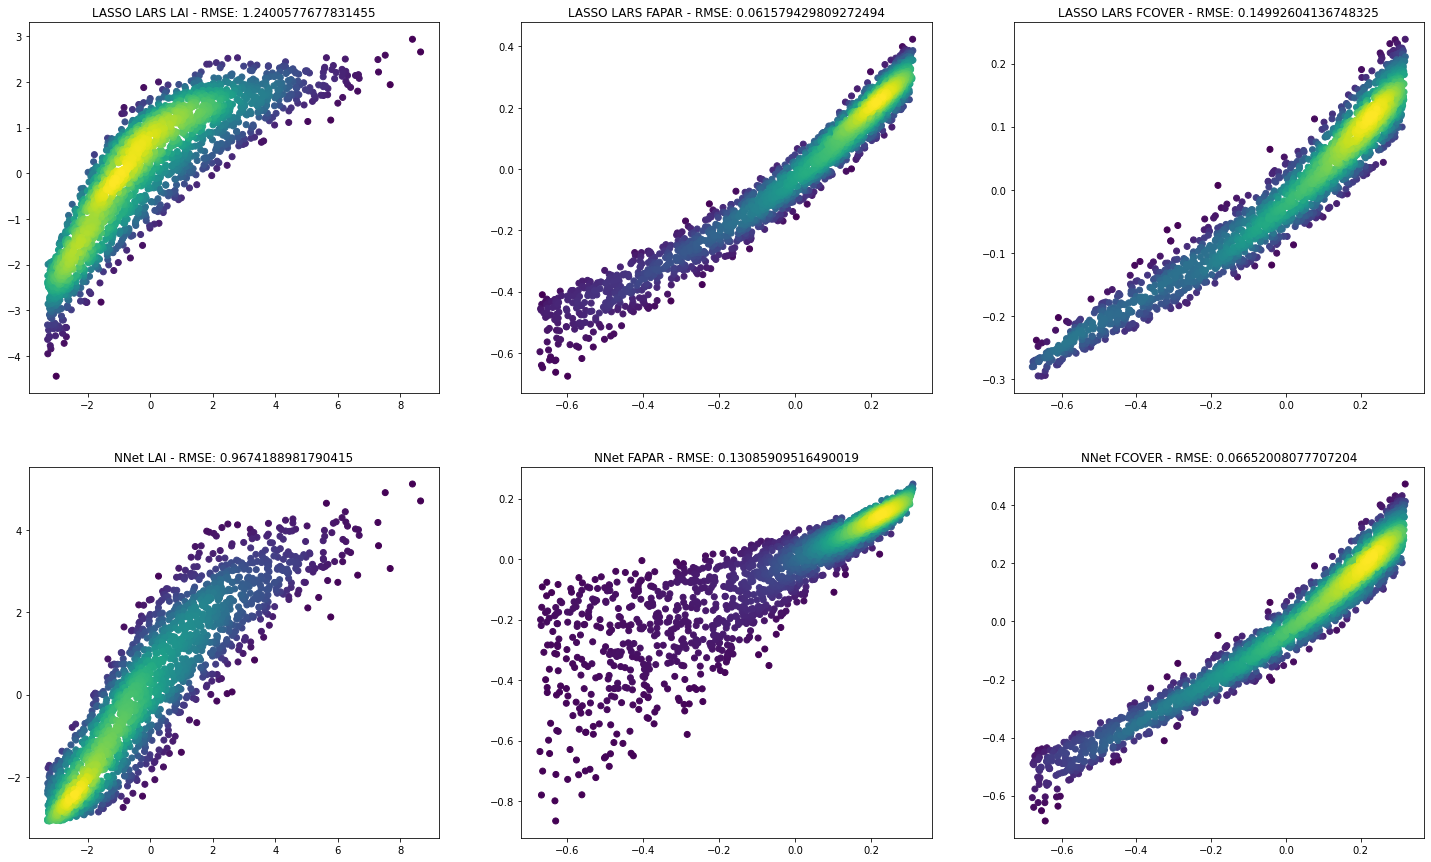

In [36]:
fig, ax = plt.subplots(2, 3, figsize=(25,15))


ax[0,0].scatter(x_skl_LAI, y_skl_LAI, c=z_skl_LAI)
#ax[0,0].plot(a_skl_LAI, a_skl_LAI, c='r')
ax[0,0].set_title('LASSO LARS LAI - RMSE: {}'.format(rmse_skl_LAI))

ax[1,0].scatter(x_tf_LAI, y_tf_LAI, c=z_tf_LAI)
#ax[1,0].plot(a_tf_LAI, a_tf_LAI, c='r')
ax[1,0].set_title('NNet LAI - RMSE: {}'.format(rmse_tf_LAI))


ax[0,1].scatter(x_skl_FAPAR, y_skl_FAPAR, c=z_skl_FAPAR)
#ax[0,1].plot(a_skl_FAPAR, a_skl_FAPAR, c='r')
ax[0,1].set_title('LASSO LARS FAPAR - RMSE: {}'.format(rmse_skl_FAPAR))


ax[1,1].scatter(x_tf_FAPAR, y_tf_FAPAR, c=z_tf_FAPAR)
#ax[1,1].plot(a_tf_FAPAR, a_tf_FAPAR, c='r')
ax[1,1].set_title('NNet FAPAR - RMSE: {}'.format(rmse_tf_FAPAR))


ax[0,2].scatter(x_skl_FCOVER, y_skl_FCOVER, c=z_skl_FCOVER)
#ax[0,2].plot(a_skl_FCOVER, a_skl_FCOVER, c='r')
ax[0,2].set_title('LASSO LARS FCOVER - RMSE: {}'.format(rmse_skl_FCOVER))


ax[1,2].scatter(x_tf_FCOVER, y_tf_FCOVER, c=z_tf_FCOVER)
#ax[1,2].plot(a_tf_FCOVER, a_tf_FCOVER, c='r')
ax[1,2].set_title('NNet FCOVER - RMSE: {}'.format(rmse_tf_FCOVER))

#plt.savefig("./matplotlib_outputs/random_sampling_w_weights.jpg")

In [ ]:
import ee
ee.Initialize()

In [ ]:
def EE_LARS_Regression(assetName, features, response, maxSamples, n_nonzero):
        
    inputCSV = ee.FeatureCollection(assetName)
    inputCSV = inputCSV.toList(count=maxSamples)
    
    def extractBands(feature):
        feature = ee.Feature(feature)
        return feature.toArray(properties=features).toList()

    def extractVI(feature):
        feature = ee.Feature(feature)
        return feature.toArray(properties=[response]).toList()
    
    inputList = inputCSV.map(extractBands)
    outputList = inputCSV.map(extractVI)
    
    X = ee.Array(inputList)
    y = ee.Array(outputList)
    
    n = X.length().get([0])
    m = X.length().get([1])
    
    
    def centre(output):
        output = ee.Array(output)
        mean = output.reduce(ee.Reducer.mean(), [0]).get([0,0])
        return output.subtract(mean)
        
    def normalize(inputs):
        inputs = ee.Array(inputs)
        
        inputMeans = inputs.reduce(ee.Reducer.mean(), [0])
        inputMeans = inputMeans.repeat(0, n)
        inputs = inputs.subtract(inputMeans)
        inputs = inputs.pow(2).reduce(ee.Reducer.sum(), [0]).pow(-0.5).repeat(0,n).multiply(inputs)
        
        return inputs
    
    X = normalize(X)
    y = centre(y)
    
    def LARSregression(iteration, inputs):
        inputs = ee.Dictionary(inputs)
        prediction = inputs.getArray('prediction')
        coeff_arr = inputs.getArray('coeff_arr')
    
        c = X.matrixTranspose().matrixMultiply(y.subtract(prediction))
        c_abs = c.abs()
        C_max = c_abs.get(c_abs.argmax())

        maxLocs = c_abs.gte(C_max.subtract(0.00001))
        signs = c.divide(c_abs)

        signs_j = maxLocs.multiply(signs).matrixTranspose()
        signs_jc = signs_j.abs().subtract(1).multiply(-1)
        
        A = ee.List(ee.Array([ee.List.sequence(0, m.subtract(1))]).mask(signs_j).toList().get(0))
        A_c = ee.List(ee.Array([ee.List.sequence(0, m.subtract(1))]).mask(signs_jc).toList().get(0))

        signMatrix_j = signs_j.repeat(0, n)

        X_A = X.multiply(signMatrix_j).mask(signs_j)
        j = X_A.length().get([1])
        
        G_A = X_A.matrixTranspose().matrixMultiply(X_A)

        V1_A = ee.Array(ee.List.repeat([1], j))

        G_Ai = G_A.matrixInverse()

        A_A = V1_A.matrixTranspose().matrixMultiply(G_Ai).matrixMultiply(V1_A).get([0,0]).pow(-0.5)

        w_A = G_Ai.matrixMultiply(V1_A).multiply(A_A)

        u_A = X_A.matrixMultiply(w_A)

        a = X.matrixTranspose().matrixMultiply(u_A)

        def computeGammaRRay(index_j):
            minus_j = C_max.subtract(c.get([index_j, 0])).divide(A_A.subtract(a.get([index_j, 0])))
            plus_j = C_max.add(c.get([index_j, 0])).divide(A_A.add(a.get([index_j, 0])))

            gammaRRay = ee.Array([minus_j, plus_j]);
            gammaRRay = gammaRRay.mask(gammaRRay.gte(0))
            gammaRRay = gammaRRay.multiply(-1)

            return gammaRRay.get(gammaRRay.argmax())

        gammaRRay = ee.Array([A_c.map(computeGammaRRay)])
        gamma = gammaRRay.get(gammaRRay.argmax()).multiply(-1)

        prediction = prediction.add(u_A.multiply(gamma))
        coefficients = X.matrixSolve(prediction)

        def setZero(num):
            num = ee.Number(num)
            return ee.Algorithms.If(num.abs().lt(0.0000000001), [0], [num])

        coefficients = ee.Array(ee.List(coefficients.matrixTranspose().toList().get(0)).map(setZero))

        coeff_arr = ee.Array.cat([coeff_arr, coefficients], axis=1)

        outputs = ee.Dictionary({'prediction':prediction, 'coeff_arr':coeff_arr})

        return outputs
    
    
    numIterations = ee.List.sequence(1, n_nonzero)
    prediction = ee.Array(ee.List.repeat([0], n))
    coeff_arr = ee.Array(ee.List.repeat([0], m))
    initial = ee.Dictionary({'prediction':prediction, 'coeff_arr':coeff_arr})

    finalOutputs = numIterations.iterate(LARSregression, initial)
    finalOutputs = ee.Dictionary(finalOutputs)
    finalPrediction = finalOutputs.getArray('prediction')

    coeff_arr = finalOutputs.getArray('coeff_arr')
    coeff_arr = coeff_arr.getInfo()
    coeff_arr = numpy.asarray(coeff_arr)
    
    return coeff_arr

In [ ]:
LAI_coef = EE_LARS_Regression('users/ccrs2fy2020/rawFeatures', 
                              ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3'], 
                              'LAI', 
                              50000, 
                              10)

In [ ]:
FAPAR_coef = EE_LARS_Regression('users/ccrs2fy2020/rawFeatures',
                                ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3'],
                                'FAPAR', 
                                50000, 
                                10)

In [ ]:
FCOVER_coef = EE_LARS_Regression('users/ccrs2fy2020/rawFeatures', 
                                 ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3'],
                                 'FCOVER', 
                                 50000, 
                                 10)

In [ ]:
LAI_coef = pandas.DataFrame(LAI_coef)
FAPAR_coef = pandas.DataFrame(FAPAR_coef)
FCOVER_coef = pandas.DataFrame(FCOVER_coef)

In [ ]:
LAI_coef

In [ ]:
FAPAR_coef

In [ ]:
FCOVER_coef